## Step A

In [13]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [14]:
query_imgs = ['0','1','11','19','24','25','26']
train_imgs = ['scenes/e1.png','scenes/e2.png','scenes/e3.png','scenes/e4.png','scenes/e5.png']
true_imgs = {
    'scenes/e1.png':{'0':1,'11':1},
    'scenes/e2.png':{'24':1,'25':1,'26':1},
    'scenes/e3.png':{'0':1,'1':1,'11':1},
    'scenes/e4.png':{'0':1,'11':1,'25':1,'26':1},
    'scenes/e5.png':{'19':1,'25':1},
}

In [15]:
MIN_MATCH_COUNT = 88
LOWE_COEFF = 0.7
NUM_EPOCHS = 2
COLOR_T = 50
CONSISTENCY_COEFF = 0.5
DIM_MIN = 0.5
DIM_MAX = 2
AREA_MIN = 0.5
AREA_MAX = 2

Scene: scenes/e1.png

7


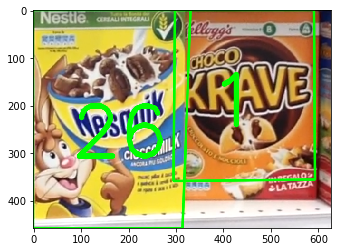

Scene: scenes/e2.png

7


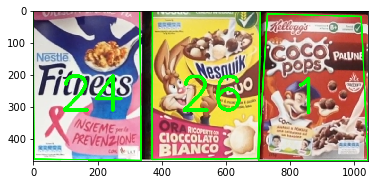

Scene: scenes/e3.png

7


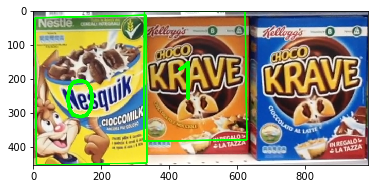

Scene: scenes/e4.png

7


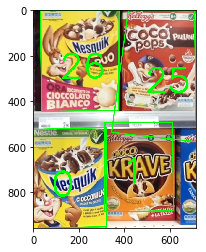

Scene: scenes/e5.png

7


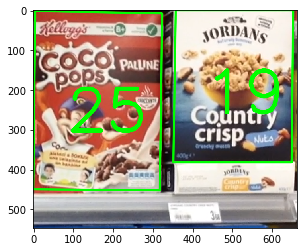

In [16]:
sift = cv2.xfeatures2d.SIFT_create()

for train_img in train_imgs:

    train = cv2.imread(train_img,0)
    train_bgr = cv2.imread(train_img)
    train_rgb = cv2.cvtColor(train_bgr,cv2.COLOR_BGR2RGB)
    
    kp_train, des_train = sift.detectAndCompute(train,None)
    
    print("Scene: "+train_img+"\n")
    
    global_matches = {}
    recognised = {}
    
    for query_img in query_imgs:
        
        file = 'models/' + query_img + '.jpg'
        query = cv2.imread(file,0)

        kp_query, des_query = sift.detectAndCompute(query,None)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)

        flann = cv2.FlannBasedMatcher(index_params, search_params)

        matches = flann.knnMatch(des_query,des_train,k=2)

        good_matches = []
        for m,n in matches:
            if m.distance < LOWE_COEFF * n.distance:
                good_matches.append(m)
                
        global_matches[query_img] = [len(good_matches),good_matches,kp_query]
    
    global_matches = dict(sorted(global_matches.items(), key=lambda item: item[1][0],reverse=True))
    
    #print(len(global_matches))
    #global_matches = sorted(global_matches,reverse=True)
    #dimensions = []
    #areas = []
    #centers = []

    
    for k,v in global_matches.items():

        print(v[0])

        if v[0] > MIN_MATCH_COUNT:
            
            file = 'models/' + k + '.jpg'
            query_bgr = cv2.imread(file)
            
            src_pts = np.float32([ v[2][m.queryIdx].pt for m in v[1]]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in v[1]]).reshape(-1,1,2)
            M, _ = cv2.findHomography(src_pts,dst_pts,cv2.RANSAC,5.0)
            h,w,d = query_bgr.shape
            pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)

        
            xCenter, yCenter = ((dst[0][0][i]+ dst[2][0][i])/2 for i in (0,1))
            
            dst2 = dst
            for i in range(4):
                for j in range(2):
                    if dst2[i][0][j]<0:
                        dst2[i][0][j]=0
                    elif dst2[i][0][j] > train.shape[j-1]:
                        dst2[i][0][j]=train.shape[j-1]

            # create mask with zeros to get ROI
            mask = np.zeros((train_rgb.shape), dtype=np.uint8)
            cv2.fillPoly(mask, np.int32(dst2), (255,255,255) )

            # get color values
            train_color = train_rgb[np.where((mask == (255,255,255)).all(axis=2))].mean(axis=0).mean(axis=0)
            query_color = query_bgr.mean(axis=0).mean(axis=0)

            color_diff = abs(query_color-train_color)

            a = True 
            if max(color_diff)<COLOR_T or True:
                for r,corners in recognised.items():
                    if xCenter>corners[0][0][0] and xCenter<corners[3][0][0] and yCenter>corners[0][0][1] and yCenter<corners[1][0][1]:
                        a = False
                        break
                if a : recognised[k] = dst

                
            
    for k,v in recognised.items():
        train_rgb = cv2.polylines(train_rgb,[np.int32(v)],True,(0,255,0),3, cv2.LINE_AA)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(train_rgb, k,\
                        (int((v[3][0][0]-v[0][0][0])/4+v[0][0][0]),int((v[1][0][1]-v[0][0][1])*0.67+v[0][0][1])),\
                        font, 5, (0,255,0), 10, cv2.LINE_AA)
    plt.imshow(train_rgb),plt.show();


            
            # x_minimum = int(np.min(dst,axis=0)[0][0])
            # y_minimum = int(np.min(dst,axis=0)[0][1])
            # x_maximum = int(np.max(dst,axis=0)[0][0])
            # y_maximum = int(np.max(dst,axis=0)[0][1])
            
            # dimensions.append(((x_maximum-x_minimum),(y_maximum-y_minimum)))
            # delta.append(np.sqrt((x_minimum-x_maximum)**2+(y_minimum-y_maximum)**2))  
            # center = (int((x_maximum+x_minimum)/2),int((y_maximum+y_minimum)/2))
            # train_crop = train[y_minimum:y_maximum,x_minimum:x_maximum]
            # train_color = train_crop.mean(axis=0).mean(axis=0)
            
            # color_diff = abs(query_color-train_color)
            # dist = []
            # area = 0
            # for i in range(3):
            #     area += dst[i][0][0]*dst[i+1][0][1]-dst[i+1][0][0]*dst[i][0][1]
            # area += dst[3][0][0]*dst[0][0][1]-dst[0][0][0]*dst[3][0][1]
            # area = abs(area/2)
            # areas.append(area)
            
            # for c in centers:
            #     dist.append(np.sqrt((center[0]-c[0])**2+(center[1]-c[1])**2))
            # min_dist = float("inf")
            # if len(dist)>0:
            #     min_dist = min(dist)
                
            # if max(color_diff)<COLOR_T and min_dist > delta[0]*CONSISTENCY_COEFF\
            #     and area/areas[0] > AREA_MIN and area/areas[0] < AREA_MAX\
            #     and (x_maximum-x_minimum)/dimensions[0][0] > DIM_MIN and (x_maximum-x_minimum)/dimensions[0][0] < DIM_MAX\
            #     and (y_maximum-y_minimum)/dimensions[0][1] > DIM_MIN and (y_maximum-y_minimum)/dimensions[0][1] < DIM_MAX\
            #     and dst[0][0][0] < dst[3][0][0]\
            #     and dst[1][0][0] < dst[2][0][0]\
            #     and dst[0][0][1] < dst[1][0][1]\
            #     and dst[3][0][1] < dst[2][0][1]:
            #     train_rgb = cv2.polylines(train_rgb,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)
            #     font = cv2.FONT_HERSHEY_SIMPLEX
            #     cv2.putText(train2, matches[0],\
            #             (int((x_maximum-x_minimum)/4+x_minimum),int((y_maximum-y_minimum)*0.67+y_minimum)),\
            #             font, 5, (0,127,255), 10, cv2.LINE_AA)
            #     plt.imshow(train_rgb),plt.show();
            
            
            
            
            
            
#            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
#            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
#            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
#            matchesMask = mask.ravel().tolist()
#            h,w,d = img1.shape
#            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
#            dst = cv2.perspectiveTransform(pts,M)
#            draw_params = dict(matchColor = (0,0,0), # draw matches in green color
#                           singlePointColor = None,
#                           matchesMask = matchesMask, # draw only inliers
#                           flags = 2)
#            print( "Product " + img + ": enough matches are found!!! - {}/{}".format(len(good), MIN_MATCH_COUNT) )
#            img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
#            plt.figure(figsize = (15,15))
#            plt.imshow(img3),plt.show();
#            if img in true_images[scene]:
#                TP += 1
#                TTP += 1
#                img2 = cv2.polylines(img2,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)
#                print("TP " + img + " (" + str(len(good)) + " matches)")
#            else:
#                FP += 1
#                TFP += 1
#                img2 = cv2.polylines(img2,[np.int32(dst)],True,(255,0,0),3, cv2.LINE_AA)
#                print("\033[1m" + "FP " + img + " (" + str(len(good)) + " matches)\033[0m")
#                problems.add(img)
#        else:
##            print( "Product " + img + ": not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
#            matchesMask = None
#            if img in true_images[scene]:
#                FN += 1
#                TFN += 1
#                print("\033[1m" + "FN " + img + " (" + str(len(good)) + " matches)\033[0m")
#                problems.add(img)
#            else:
#                TN += 1
#                TTN += 1
#                print("TN " + img + " (" + str(len(good)) + " matches)")
#    print("\n" + "TP: " + str(TP) + "\t" + "FP: " + str(FP) + "\t" + "TN: " + str(TN) + "\t" + "FN: " + str(FN) + "\n")
#    print("Accuracy: %.2f" % ((TP+TN)/(TP+FP+TN+FN)*100) + "%\t"+"Precision: %.2f" % (TP/(TP+FP)*100) + "%")
#    print("Sensitivity: %.2f" % (TP/(TP+FN)*100) + "%\t"+"Specificity: %.2f" % (TN/(TN+FP)*100) + "%")
#    print("F score: %.2f" % (2*((TP/(TP+FP))*(TP/(TP+FN)))/((TP/(TP+FP))+(TP/(TP+FN)))))
#    plt.imshow(img2),plt.show();
#    print("\n")
#print("\n\033[1m" + "TTP: " + str(TTP) + "\t" + "TFP: " + str(TFP) + "\t" + "TTN: " + str(TTN) + "\t" + "TFN: " + str(TFN) + "\033[0m\n")
#print("\033[1m" + "Total accuracy: %.2f" % ((TTP+TTN)/(TTP+TFP+TTN+TFN)*100) + "%\t\t"+"Total precision: %.2f" % (TTP/(TTP+TFP)*100) + "%\033[0m")
#print("\033[1m" + "Total sensitivity: %.2f" % (TTP/(TTP+TFN)*100) + "%\t"+"Total specificity: %.2f" % (TTN/(TTN+TFP)*100) + "%\033[0m")
#print("\033[1m" + "Total F score: %.2f" % (2*((TTP/(TTP+TFP))*(TTP/(TTP+TFN)))/((TTP/(TTP+TFP))+(TTP/(TTP+TFN)))) + "\033[0m")

#print("\n\n" + "Problematic images: ")
#for img in problems:
#    img1_bgr = cv2.imread(img)
#    img1 = cv2.cvtColor(img1_bgr,cv2.COLOR_BGR2RGB)
#    plt.imshow(img1),plt.show();